
# <span style="color:green">__Machine Learning for the Kickstarter Challenge__
----



## <span style="color:navy">__Set-up and Import__

In [23]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timezone
import json

# Libraries for data import
import os
import glob

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Set random seed 
RSEED = 42

#To import XGBoost, as it was not working in VS code.
#import pip 
#pip.main(['install', 'xgboost'])
import xgboost as xgb
from xgboost import XGBClassifier

# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

In [24]:
df = pd.read_csv('data/df_cleaned_for_ML.csv')

In [25]:
df.head(5)

,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,...,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
0,47,games,US,2017-08-02 16:28:13,2017-09-09 19:00:59,928751314,False,2017-08-10 19:00:59,False,successful,...,8,1,10,9,0,0,19,19,41.49,195.00
1,271,music,US,2012-09-30 08:45:33,2013-06-12 07:03:15,928014092,False,2013-05-13 07:03:15,False,successful,...,17,1,13,12,3,3,7,7,82.67,149.36
2,3,games,GB,2017-01-07 10:11:11,2017-03-13 18:22:56,596091328,False,2017-01-12 19:22:56,False,failed,...,5,1,12,13,22,22,19,18,55.13,1.36
3,3,publishing,US,2012-12-06 19:04:31,2013-01-09 21:32:07,998516049,False,2012-12-10 21:32:07,False,successful,...,4,1,10,9,32,32,21,21,940.00,100.71
4,35,music,US,2014-10-24 19:35:50,2015-05-02 04:25:46,1224600291,False,2015-04-02 04:25:46,False,successful,...,22,0,2,2,25,25,4,4,106.43,106.43


---
## <span style="color:navy">__The Data__


In [27]:
#Print the shape of the data
print('Kickstarter dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Kickstarter dataset
# observations: 192664
# features:     24


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192664 entries, 0 to 192663
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   backers_count            192664 non-null  int64  
 1   category                 192664 non-null  object 
 2   country                  192664 non-null  object 
 3   created_at               192664 non-null  object 
 4   deadline                 192664 non-null  object 
 5   id                       192664 non-null  int64  
 6   is_starrable             192664 non-null  bool   
 7   launched_at              192664 non-null  object 
 8   staff_pick               192664 non-null  bool   
 9   state                    192664 non-null  object 
 10  usd_pledged              192664 non-null  float64
 11  blurb_length             192664 non-null  int64  
 12  sub_category             192664 non-null  object 
 13  usd_goal                 192664 non-null  float64
 14  name

In [31]:
# Dropping columns and creating new dataframe
df = df.drop(['id', 'backers_count', 'created_at', 'deadline', 'launched_at', 'usd_pledged', 'pledge_per_backer', 'percent_pledged', 'sub_category'], axis=1)
df.head()

,category,country,is_starrable,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
0,games,US,False,False,successful,22,1000.00,4,8,1,10,9,0,0,19,19
1,music,US,False,False,successful,15,15000.00,7,17,1,13,12,3,3,7,7
2,games,GB,False,False,failed,23,12160.66,8,5,1,12,13,22,22,19,18
3,publishing,US,False,False,successful,24,2800.00,7,4,1,10,9,32,32,21,21
4,music,US,False,False,successful,18,3500.00,4,22,0,2,2,25,25,4,4


> Correlation Matrix

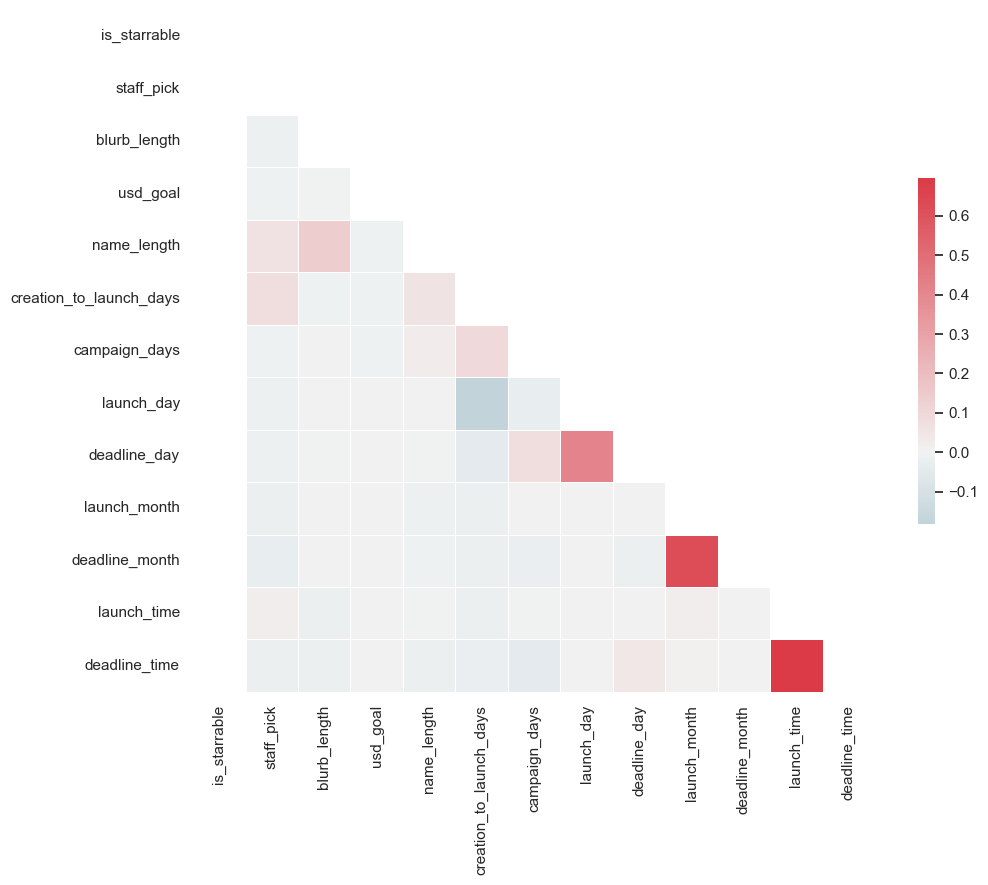

In [32]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});


> The dependent variable will now be converted into 1s (successful) and 0s (failure):

In [33]:
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})

In [34]:
df.dtypes

category                    object
country                     object
is_starrable                  bool
staff_pick                    bool
state                        int64
blurb_length                 int64
usd_goal                   float64
name_length                  int64
creation_to_launch_days      int64
campaign_days                int64
launch_day                   int64
deadline_day                 int64
launch_month                 int64
deadline_month               int64
launch_time                  int64
deadline_time                int64
dtype: object

In [35]:
df['staff_pick'] = df['staff_pick'].astype(str)
df['is_starrable'] = df['is_starrable'].astype(str)


In [37]:
# Creating list for categorical predictors/features 

cat_features = list(df.columns[df.dtypes==object])
cat_features

['category', 'country', 'is_starrable', 'staff_pick']

In [38]:
# Creating list for numerical predictors/features
# Since 'state' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('state')
num_features


['blurb_length',
 'usd_goal',
 'name_length',
 'creation_to_launch_days',
 'campaign_days',
 'launch_day',
 'deadline_day',
 'launch_month',
 'deadline_month',
 'launch_time',
 'deadline_time']

---
## <span style="color:navy">__Train-Test-Split__


In [39]:
# Define predictors and target variable
X = df.drop('state', axis=1)
y = df['state']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 192664 observations in our dataset and 15 features
Our target vector has also 192664 values


In [40]:
# Split into train and test set 
RSEED =42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

In [41]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (144498, 15)
X_test shape: (48166, 15)
y_train shape: (144498,)
y_test shape: (48166,)


---
## <span style="color:navy">__Baseline Model__

In [42]:
# Simple model by usd_goal:
df_pclass = pd.DataFrame(X_test['usd_goal'])

base_model_pred = df_pclass.applymap(lambda x: 0 if x >= 4000   else 1)

In [43]:
f1_basemodel = f1_score(y_test, base_model_pred)
f1_basemodel

In [45]:
accuracy_base = accuracy_score(y_test, base_model_pred)
recall_base = recall_score(y_test, base_model_pred)
precision_base = precision_score(y_test, base_model_pred)
f1_base = f1_score(y_test, base_model_pred)

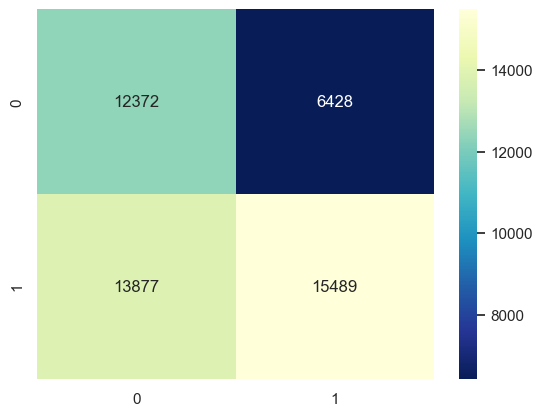

In [46]:
cm = confusion_matrix(y_test, base_model_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

---
## <span style="color:navy">__Preprocessing Pipeline__


In [48]:
# Pipeline for numerical features

num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [49]:
# Preprocessor for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

---
## <span style="color:navy">__Predictive Modelling using Pipelines__



### <span style="color:blue">__1. Logistic Regression__

In [50]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])


### <span style="color:blue">__2. Random Forest__

In [51]:
# Random Forests with default settings
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
                    ('pipe_rf', RandomForestClassifier())])
pipe_rf.fit(X_train, y_train)
print("Score:", round(pipe_rf.score(X_test, y_test),5))

Score: 0.77758



### <span style="color:blue">__3. XGBoost__

In [52]:
# XGBoost with default settings
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
                    ('pipe_xgb', xgb.XGBClassifier())])
pipe_xgb.fit(X_train, y_train)
print("Score:", round(pipe_xgb.score(X_test, y_test),5))

Score: 0.75584



### <span style="color:blue">__4. Logistic Regression with Grid Search & Cross Validation__

In [53]:
# Defining parameter space for grid-search
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='f1', 
                           verbose=5, n_jobs=-1)

In [54]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.6s
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.6s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.768 total time=   1.0s
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.769 total time=   1.1s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.769 total time=   1.1s
[CV 4/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.770 total time=   1.1s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.765 total time=   1.2s
[CV 4/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total tim

/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.773 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.5min
[CV 5/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.772 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.5min
[CV 2/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.790 total time=   9.9s
[CV 3/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.787 total time=  12.5s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.789 total time=  14.3s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.5s
[CV 2/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.5s
[CV 3/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 4/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 5/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=sag;, score=nan total time=   0.4s


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.787 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.788 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.785 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.789 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.787 total time= 1.2min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.789 total time= 1.2min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.786 total time= 1.2min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.786 total time=  50.2s


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.790 total time=  51.5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['blurb_length',
                                                                          'usd_goal',
                                                                          'name_length',
                                                                          'creation_to_launch_days',
                                  

In [55]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.79
Best parameters:
{'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [56]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid_logreg.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['blurb_length', 'usd_goal',
                                                   'name_length',
                                                   'creation_to_launch_days',
                                                   'campaign_days',
                                                   'launch_day', 'deadline_day',
                                                   'launch_month',
                                                   'deadline_month',
                                                 

---
## <span style="color:navy">__Model Performance on Train Data:__

In [57]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted_logreg = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)
y_train_predicted_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5)
y_train_predicted_xgb = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)
y_train_predicted = best_model.predict(X_train)

In [58]:
accuracy_logreg = accuracy_score(y_train, y_train_predicted_logreg)
recall_logreg = recall_score(y_train, y_train_predicted_logreg)
precision_logreg = precision_score(y_train, y_train_predicted_logreg)
f1_logreg = f1_score(y_train, y_train_predicted_logreg)

accuracy_rf = accuracy_score(y_train, y_train_predicted_rf)
recall_rf = recall_score(y_train, y_train_predicted_rf)
precision_rf = precision_score(y_train, y_train_predicted_rf)
f1_rf = f1_score(y_train, y_train_predicted_rf)

accuracy_xgb = accuracy_score(y_train, y_train_predicted_xgb)
recall_xgb = recall_score(y_train, y_train_predicted_xgb)
precision_xgb = precision_score(y_train, y_train_predicted_xgb)
f1_xgb = f1_score(y_train, y_train_predicted_xgb)

accuracy_cvgridsearch = accuracy_score(y_train, y_train_predicted)
recall_cvgridsearch = recall_score(y_train, y_train_predicted)
precision_cvgridsearch = precision_score(y_train, y_train_predicted)
f1_cvgridsearch = f1_score(y_train, y_train_predicted)

In [59]:
validation_scores_X_train = pd.DataFrame([
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_train.index = ['logreg','gridsearchCV_logreg','random_forest','xgboost']
print('Validation Metrics for Train Data:')
validation_scores_X_train

Validation Metrics for Train Data:


,accuracy,recall,precision,f1
logreg,0.718259,0.856775,0.728764,0.787602
gridsearchCV_logreg,0.719795,0.858591,0.729618,0.788868
random_forest,0.771035,0.877513,0.776169,0.823736
xgboost,0.756094,0.858625,0.768482,0.811057


---
## <span style="color:navy">__Model Performance on the Test Data:__

In [60]:
y_test_predicted = best_model.predict(X_test)
y_test_predicted_logreg = cross_val_predict(pipe_logreg, X_test, y_test, cv=5)
y_test_predicted_rf = cross_val_predict(pipe_rf, X_test, y_test, cv=5)
y_test_predicted_xgb = cross_val_predict(pipe_xgb, X_test, y_test, cv=5)

In [61]:
accuracy_logreg_test = accuracy_score(y_test, y_test_predicted_logreg)
recall_logreg_test = recall_score(y_test, y_test_predicted_logreg)
precision_logreg_test = precision_score(y_test, y_test_predicted_logreg)
f1_logreg_test = f1_score(y_test, y_test_predicted_logreg)

accuracy_rf_test = accuracy_score(y_test, y_test_predicted_rf)
recall_rf_test = recall_score(y_test, y_test_predicted_rf)
precision_rf_test = precision_score(y_test, y_test_predicted_rf)
f1_rf_test = f1_score(y_test, y_test_predicted_rf)

accuracy_xgb_test = accuracy_score(y_test, y_test_predicted_xgb)
recall_xgb_test = recall_score(y_test, y_test_predicted_xgb)
precision_xgb_test = precision_score(y_test, y_test_predicted_xgb)
f1_xgb_test = f1_score(y_test, y_test_predicted_xgb)

accuracy_cvgridsearch_test = accuracy_score(y_test, y_test_predicted)
recall_cvgridsearch_test = recall_score(y_test, y_test_predicted)
precision_cvgridsearch_test = precision_score(y_test, y_test_predicted)
f1_cvgridsearch_test = f1_score(y_test, y_test_predicted)

In [62]:
validation_scores_X_test = pd.DataFrame([
                                  [accuracy_logreg_test, recall_logreg_test,precision_logreg_test,f1_logreg_test],
                                  [accuracy_cvgridsearch_test, recall_cvgridsearch_test,precision_cvgridsearch_test,f1_cvgridsearch_test],
                                  [accuracy_rf_test,recall_rf_test,precision_rf_test,f1_rf_test],
                                  [accuracy_xgb_test,recall_xgb_test,precision_xgb_test ,f1_xgb_test]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_test.index = ['logreg','gridsearchCV_logreg','random_forest','xgboost']
print('Validation Metrics for Test Data:')
validation_scores_X_test

Validation Metrics for Test Data:


,accuracy,recall,precision,f1
logreg,0.717581,0.856569,0.728152,0.787157
gridsearchCV_logreg,0.720218,0.860859,0.729161,0.789556
random_forest,0.750696,0.861064,0.761305,0.808118
xgboost,0.746066,0.843969,0.764160,0.802084



### <span style="color:black">__> Confusion Matrices:__

> Logistic Regression:

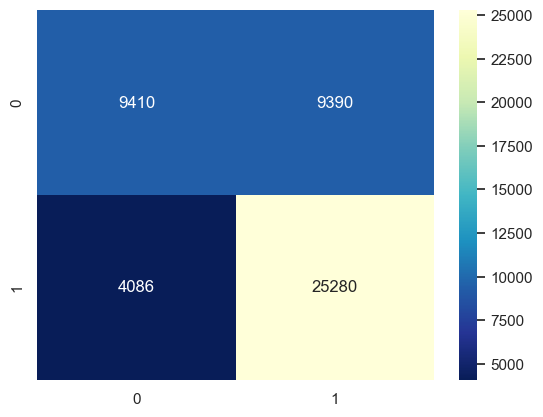

In [63]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

> XGBoost:

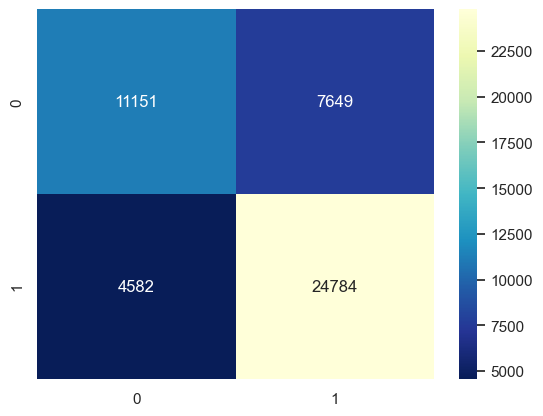

In [64]:
cm = confusion_matrix(y_test, y_test_predicted_xgb)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

> Random Forest:

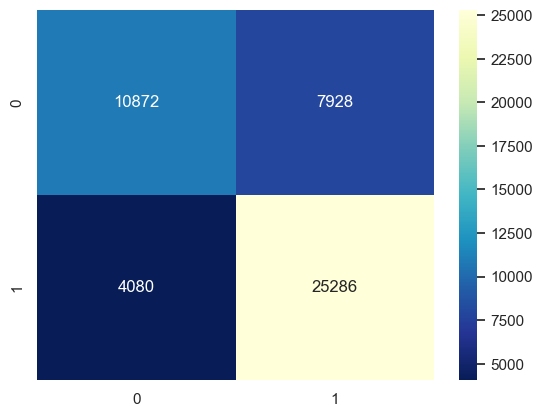

In [65]:
cm = confusion_matrix(y_test, y_test_predicted_rf)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

> LogReg Grid Search & CV

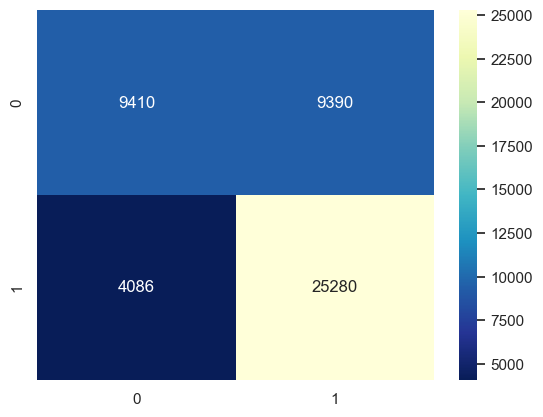

In [66]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

---
## <span style="color:navy">__Final Performance Metrics Comparison__

In [67]:
validation_scores_X_test = pd.DataFrame([
                                  [accuracy_base, recall_base,precision_base,f1_base],
                                  [accuracy_logreg_test, recall_logreg_test,precision_logreg_test,f1_logreg_test],
                                  [accuracy_cvgridsearch_test, recall_cvgridsearch_test,precision_cvgridsearch_test,f1_cvgridsearch_test],
                                  [accuracy_rf_test,recall_rf_test,precision_rf_test,f1_rf_test],
                                  [accuracy_xgb_test,recall_xgb_test,precision_xgb_test ,f1_xgb_test]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_test.index = ['base model','logreg','gridsearchCV_logreg','random_forest','xgboost']
print('Model Comparison:')
validation_scores_X_test

Model Comparison:


,accuracy,recall,precision,f1
base model,0.578437,0.527447,0.706712,0.604060
logreg,0.717581,0.856569,0.728152,0.787157
gridsearchCV_logreg,0.720218,0.860859,0.729161,0.789556
random_forest,0.750696,0.861064,0.761305,0.808118
xgboost,0.746066,0.843969,0.764160,0.802084
